1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

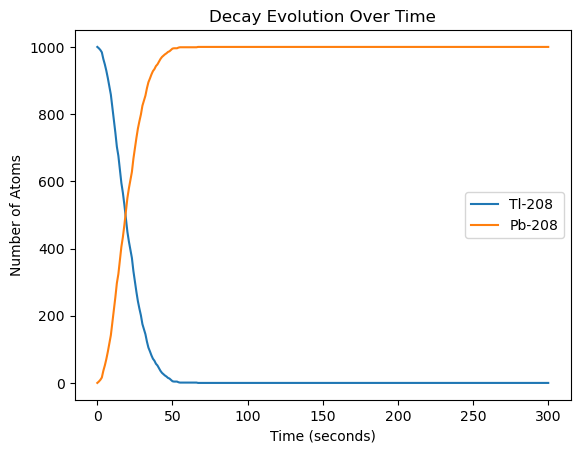

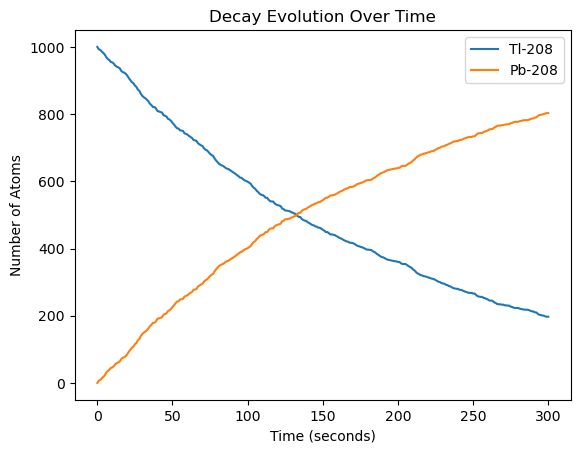

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Decay simulation using probability function
def simulate_decay_prob(num_atoms, decay_constant, total_time):
    tl_atoms = num_atoms
    pb_atoms = 0
    tl_counts = [tl_atoms]
    pb_counts = [pb_atoms]

    for time_step in range(1, total_time + 1):
        decay_prob = 1 - 2**(-time_step / decay_constant)
        decayed_tl = np.random.binomial(tl_atoms, decay_prob)
        tl_atoms -= decayed_tl
        pb_atoms += decayed_tl

        tl_counts.append(tl_atoms)
        pb_counts.append(pb_atoms)

    return tl_counts, pb_counts

# Inverse transform method
def inverse_transform_sampling(num_samples, decay_constant):
    uniform_samples = np.random.uniform(0, 1, num_samples)
    times_of_decay = -decay_constant * np.log(1 - uniform_samples)
    return times_of_decay

# Plotting function
def plot_decay_evolution(tl_counts, pb_counts, total_time):
    time_steps = np.arange(0, total_time + 1)

    plt.plot(time_steps, tl_counts, label='Tl-208')
    plt.plot(time_steps, pb_counts, label='Pb-208')
    plt.title('Decay Evolution Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Atoms')
    plt.legend()
    plt.show()


num_atoms = 1000
decay_constant = 3.052 * 60 
total_time = 300  

# Simulate decay using probability function
tl_counts_prob, pb_counts_prob = simulate_decay_prob(num_atoms, decay_constant, total_time)

# Inverse transform method
decay_times = inverse_transform_sampling(num_atoms, decay_constant)
decay_times.sort()

# Count non-decayed atoms at each time step
tl_counts_inverse = [num_atoms - np.searchsorted(decay_times, t) for t in range(total_time + 1)]
pb_counts_inverse = [num_atoms - tl_count for tl_count in tl_counts_inverse]

# Plot results
plot_decay_evolution(tl_counts_prob, pb_counts_prob, total_time)
plot_decay_evolution(tl_counts_inverse, pb_counts_inverse, total_time)


2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

Hit or Miss Method:
Mean Value of Integral: 1.3542
Standard Deviation of Integral (Rescaled): 0.0
Integral: 1.337 +- 0.007

Comparing the two methods it seems that in this case the mean-value estimate performs better than hit-miss estimate


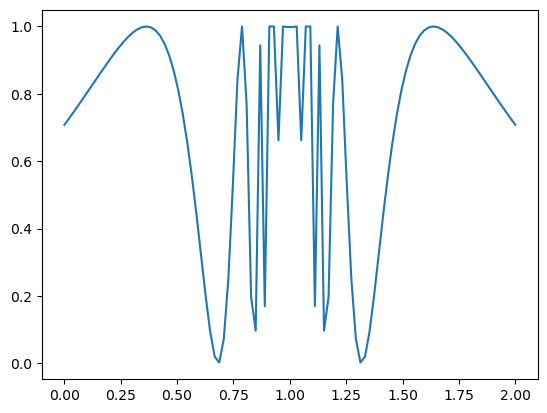

In [32]:
import random 

def f(x):
    return np.sin(1/(1-x))**2

x = np.linspace(0,2,100)

plt.figure()
plt.plot(x,f(x))

N = 10000
integrals = 0 
for i in range(N):
    y = random.uniform(0,1)
    x = random.uniform(0,2)
    if y < f(x):
        integrals += 1
        
under = integrals /N
integral = 2 * under

mean_integral = np.mean(integral)
std_dev_integral = np.std(integral) / np.sqrt(N) 

print("Hit or Miss Method:")
print("Mean Value of Integral:", mean_integral)
print("Standard Deviation of Integral (Rescaled):", std_dev_integral)

    
def mean_value(x_min, x_max, n):
    xi = np.random.uniform(x_min, x_max, n)
    yi = np.array([f(xii) for xii in xi])
    s = np.sum(yi)
    integ = (x_max - x_min) / n * s
    return integ

integr = mean_value(0, 2, N)
M = 100

def calc_sigma(x_min, x_max, n, m):
    # Calculate the integral m times
    integrs = np.array([mean_value(x_min, x_max, n) for mi in np.arange(m)])
    # Estimate sigma^2 as <I^2> - <I>^2
    sigma = np.sqrt(np.mean(integrs**2) - np.mean(integrs)**2)
    return sigma

sigma = calc_sigma(0, 2, N, M)
print("Integral: %.3f +- %.3f" % (integr, sigma))


print()
print('Comparing the two methods it seems that in this case the mean-value estimate performs better than hit-miss estimate')

3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [45]:
# Monte Carlo integration
N = 100000
count = 0

for i in range(N):
    x =  np.random.random()
    y = np.random.random()    
    if  x**2 +y**2 <= 1: 
        count += 1
        
I = 4*count / N
print("Integral:", I)

A = 0
x = np.zeros(10)
for i in range(N):
    for j in range(10):
        x[j] = random.random()
    if np.linalg.norm(x) <= 1:
        A += 1
print('estimated integral value:', (2**10 *A)/N)

Integral: 3.14816
estimated integral value: 2.51904


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [47]:
import math

def g(x):
    return 1.0/(1.0 + math.exp(x))

N = 1000000
x = np.random.random(size=N)
#the inverse of the cumulative probability function is x^2
y = np.array([g(xval**2) for xval in x])
s = np.sum(y) / N

# Integral in interval [0,1] of w(x) is 2
I = 2.0*s
print(I)


0.8387491424942288
